In [13]:
import warnings
warnings.filterwarnings("ignore")

# Importing required libraries.

In [14]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import itertools
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import yfinance as yf

# Downloaded the data using the code given and split it into train and test.

In [15]:
ticker_symbol = 'ULTRACEMCO.NS'
start_date = '2021-01-01'
end_date = '2023-05-31'

# Download the data from Yahoo Finance
df = yf.download(ticker_symbol, start=start_date, end=end_date)

# Reset the index
df = df.reset_index(drop=True)

# Extract the 'Close' column
df = df[['Close']]

# Create train and test dataframes
train_end_date = df.index[-100]  # Last 100 days for test, remaining for train
train = df.iloc[:train_end_date]
test = df.iloc[train_end_date:]

[*********************100%***********************]  1 of 1 completed


In [16]:
df.shape,train.shape,test.shape

((596, 1), (496, 1), (100, 1))

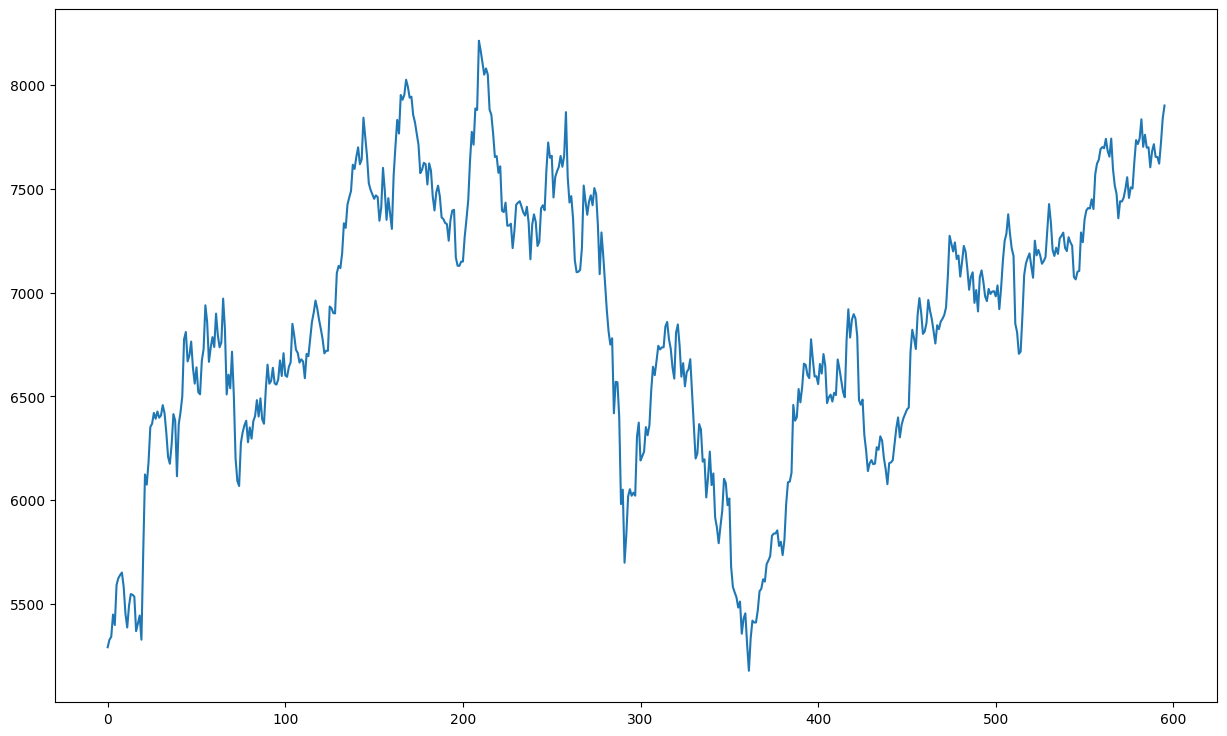

In [17]:
df['Close'].plot(figsize=(15,9))
plt.show()

# Testing for Stationarity

In [18]:
# Perform ADF test
adf_result = adfuller(train['Close'], autolag='AIC')

# Extract the ADF test results
adf_test_statistic = adf_result[0]
adf_critical_values = adf_result[4]
adf_p_value = adf_result[1]
adf_required_differencing = adf_result[2]

# Print the ADF test results
print(f"ADF Test Statistic: {adf_test_statistic}")
print("Critical Values:")
for key, value in adf_critical_values.items():
    print(f"\t{key}: {value}")
print(f"p-value: {adf_p_value}")
print(f"Required Differencing (d): {adf_required_differencing}")

ADF Test Statistic: -2.4517986671328837
Critical Values:
	1%: -3.4437112724287253
	5%: -2.8674324209387345
	10%: -2.569908433637385
p-value: 0.12764687306726974
Required Differencing (d): 3


# Plotting ACF & PACF plots.

<Figure size 1200x600 with 0 Axes>

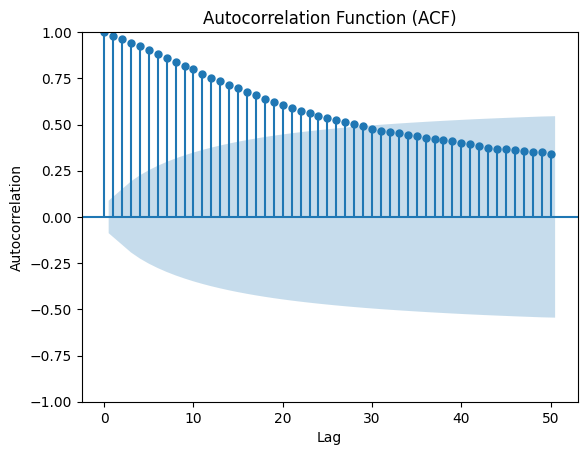

<Figure size 1200x600 with 0 Axes>

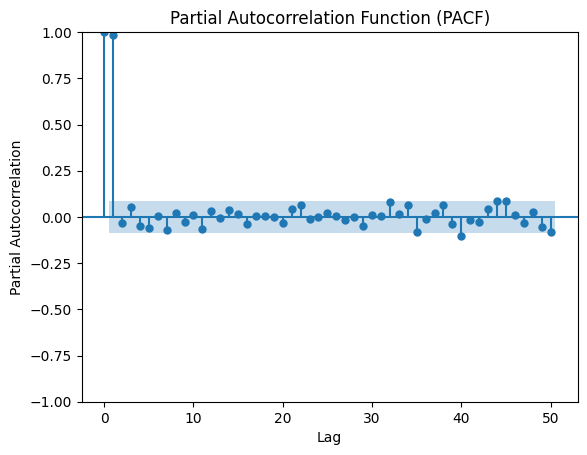

In [19]:
# Extract the 'Close' column into a separate series
close_series = train['Close']

# Plot the Autocorrelation Function (ACF)
plt.figure(figsize=(12, 6))
plot_acf(close_series, lags=50)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot the Partial Autocorrelation Function (PACF)
plt.figure(figsize=(12, 6))
plot_pacf(close_series, lags=50)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show();

# Building a baseline ARIMA(1,1,1) model

In [20]:
# Fit ARIMA model to the training data
model = ARIMA(train['Close'], order=(1, 1, 1))
model_fit = model.fit()

# Make predictions on the test data
baseline_pred = pd.DataFrame(model_fit.forecast(100))

# Print model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  496
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3028.172
Date:                Mon, 12 Jun 2023   AIC                           6062.343
Time:                        19:31:48   BIC                           6074.957
Sample:                             0   HQIC                          6067.295
                                - 496                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5010      0.370     -1.353      0.176      -1.227       0.225
ma.L1          0.5677      0.353      1.610      0.107      -0.123       1.259
sigma2      1.206e+04    592.683     20.352      0.0

# Evaluating the baseline model

# Hypotheses and test results

# Plotting diagnostics

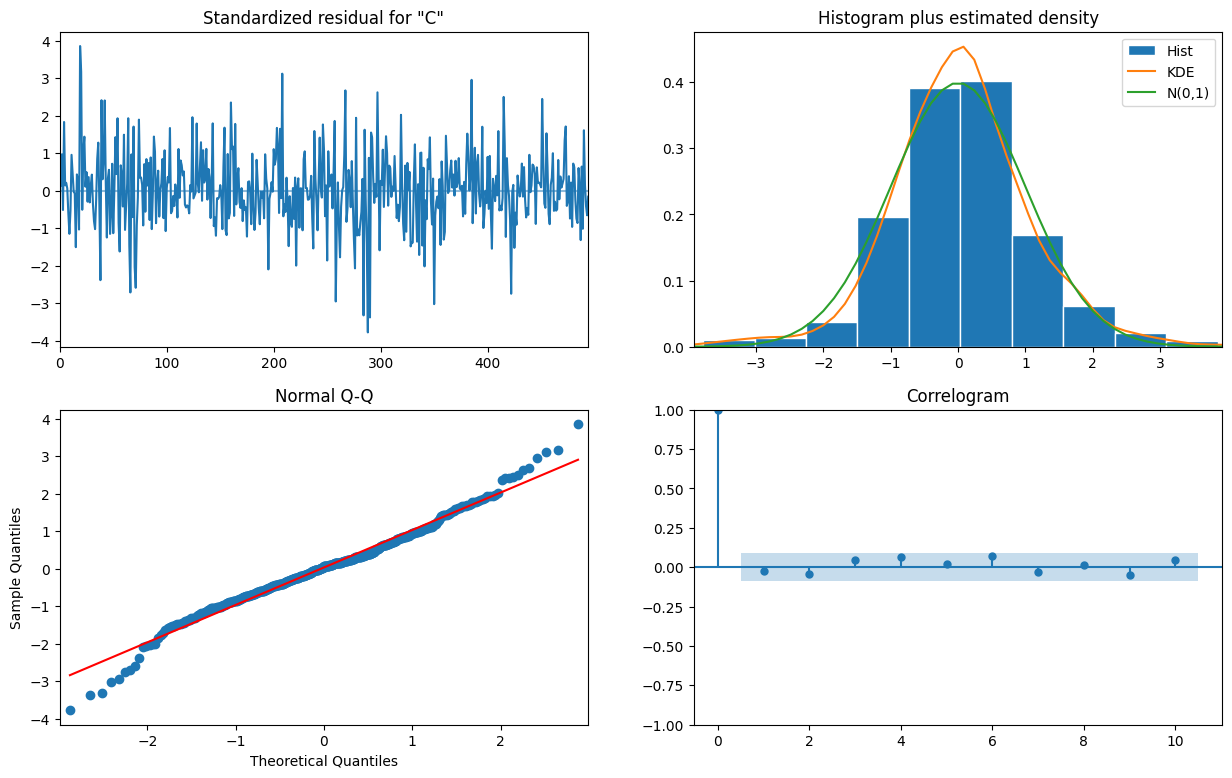

In [21]:
# plotting results
model_fit.plot_diagnostics(figsize=(15,9))
plt.show()

# Optimizing the p,d & q values using brute-force method

In [22]:
# Define p, d, q range
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)

# Define an empty list to store evaluation results
evaluation_results = []

# Iterate over all combinations of p, d, q
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                # Fit ARIMA model
                model = ARIMA(train['Close'], order=(p, d, q))
                model_fit = model.fit()

                # Calculate evaluation criterion (e.g., AIC)
                evaluation_criterion = model_fit.aic

                # Append evaluation results
                evaluation_results.append((p, d, q, evaluation_criterion))
            except:
                continue

# Sort the evaluation results based on the evaluation criterion (e.g., AIC)
evaluation_results.sort(key=lambda x: x[3])

# Print the best combination of p, d, q values
best_p, best_d, best_q, best_criterion = evaluation_results[0]
print(f"Best p, d, q values: {best_p}, {best_d}, {best_q}")
print(f"Best criterion (AIC): {best_criterion}")


Best p, d, q values: 0, 2, 1
Best criterion (AIC): 6058.37276072697


# Optimizing the p,d & q values using autoarima

In [23]:
# Use auto_arima to find best p, d, q values
model = auto_arima(train['Close'], seasonal=False,trace=True)

# Print the best p, d, q values
print(f"Best p, d, q values: {model.order}")
print(f"Best criterion (AIC): {model.aic()}")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6065.203, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6062.817, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6064.153, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6064.042, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6061.281, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6063.914, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.544 seconds
Best p, d, q values: (0, 1, 0)
Best criterion (AIC): 6061.280805898652


Here, we are getting ARIMA(0,1,0) as our best model but we will use a slightly complex model ARIMA(0,1,1) other than the base model.

# Building the arima model suggested by brute-force and autoarima

In [25]:
# Fit ARIMA model to the training data
model = ARIMA(train['Close'], order=(0,1,1))
model_fit = model.fit()

# Make predictions on the test data
arima_pred = pd.DataFrame(model_fit.forecast(100))

# Print model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  496
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -3029.229
Date:                Mon, 12 Jun 2023   AIC                           6062.459
Time:                        19:42:58   BIC                           6070.868
Sample:                             0   HQIC                          6065.760
                                - 496                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0446      0.039      1.157      0.247      -0.031       0.120
sigma2      1.217e+04    600.017     20.278      0.000     1.1e+04    1.33e+04
Ljung-Box (L1) (Q):                   0.01   Jarque-

# Evaluating the results

The SARIMAX model results provide information about the estimated coefficients, their standard errors, and statistical significance. Let's interpret the components of the output:

Model: The model used is an ARIMA(0, 1, 1), which means it is an autoregressive integrated moving average model with a differencing order of 1 and a moving average order of 1.

Dependent Variable: The variable being predicted is the "Close" price.

No. Observations: The number of data points used in the model is 496.

Log Likelihood: The log-likelihood of the model is -3029.229, which is a measure of how well the model fits the data. Higher values indicate a better fit.

AIC (Akaike Information Criterion): The AIC value is 6062.459, which is used for model selection. Lower AIC values indicate a better model fit.

BIC (Bayesian Information Criterion): The BIC value is 6070.868. Similar to AIC, BIC is another criterion for model selection, and lower values indicate a better fit.

Sample: The sample range of the data used in the model is from 0 to 496.

Covariance Type: The covariance type used in the model estimation is "opg" (outer product of gradients).

Coefficients: The coefficients section provides information about the estimated coefficients for the model. In this case, there is only one coefficient listed, which corresponds to the moving average term (ma.L1). The estimated coefficient is 0.0446, indicating the impact of the lagged value of the dependent variable on the current value.

Std Err: The standard error associated with the estimated coefficient is given as 0.039.

P-value (P>|z|): The p-value associated with the estimated coefficient tests the null hypothesis that the coefficient is equal to zero. In this case, the p-value for the ma.L1 coefficient is 0.247, which is larger than the typical threshold of 0.05. Therefore, we cannot reject the null hypothesis and conclude that the coefficient is statistically significant.

Sigma2: Sigma2 represents the estimated variance of the residuals in the model. In this case, it is 1.217e+04.

The remaining components in the output provide additional statistical measures and diagnostics for the model, including Ljung-Box test results for residual autocorrelation (Q), Jarque-Bera test results for residual normality (JB), heteroskedasticity test results (H), and related probabilities and measures. These diagnostics help assess the model's goodness of fit and assumptions.

Overall, the SARIMAX model suggests that the lagged value of the dependent variable has a small positive impact on the current value, but it is not statistically significant. The model exhibits heteroskedasticity, and the residuals' normality and autocorrelation assumptions should be further evaluated based on the provided test results.

# Hypotheses and test results

The SARIMAX model results indicate the following:

1. Hypothesis: The null hypothesis for the model coefficients is that the coefficient is equal to zero.

2. Test results: The coefficients for the model are as follows:
   - The coefficient for ma.L1 (moving average lag 1) is 0.0446 with a standard error of 0.039. The p-value associated with this coefficient is 0.247, which is greater than the significance level of 0.05. Therefore, we fail to reject the null hypothesis for this coefficient.

3. Other results:
   - The estimated variance (sigma^2) is 1.217e+04 with a standard error of 600.017.
   - The Ljung-Box statistic (Q) for the first lag is 0.01, with a probability (Prob(Q)) of 0.92. This suggests that the model residuals exhibit no significant autocorrelation at lag 1.
   - The Jarque-Bera statistic (JB) is 40.45, with a probability (Prob(JB)) of 0.00. This indicates that the model residuals deviate from a normal distribution.
   - The Heteroskedasticity statistic (H) is 0.73, with a two-sided probability (Prob(H)) of 0.05. This suggests the presence of heteroskedasticity in the model residuals.

Overall, the model suggests that the coefficient for ma.L1 is not statistically significant, and the model residuals exhibit some deviations from normality and the presence of heteroskedasticity. Further analysis and diagnostics may be required to improve the model's fit and reliability.

# Plotting model diagnostics

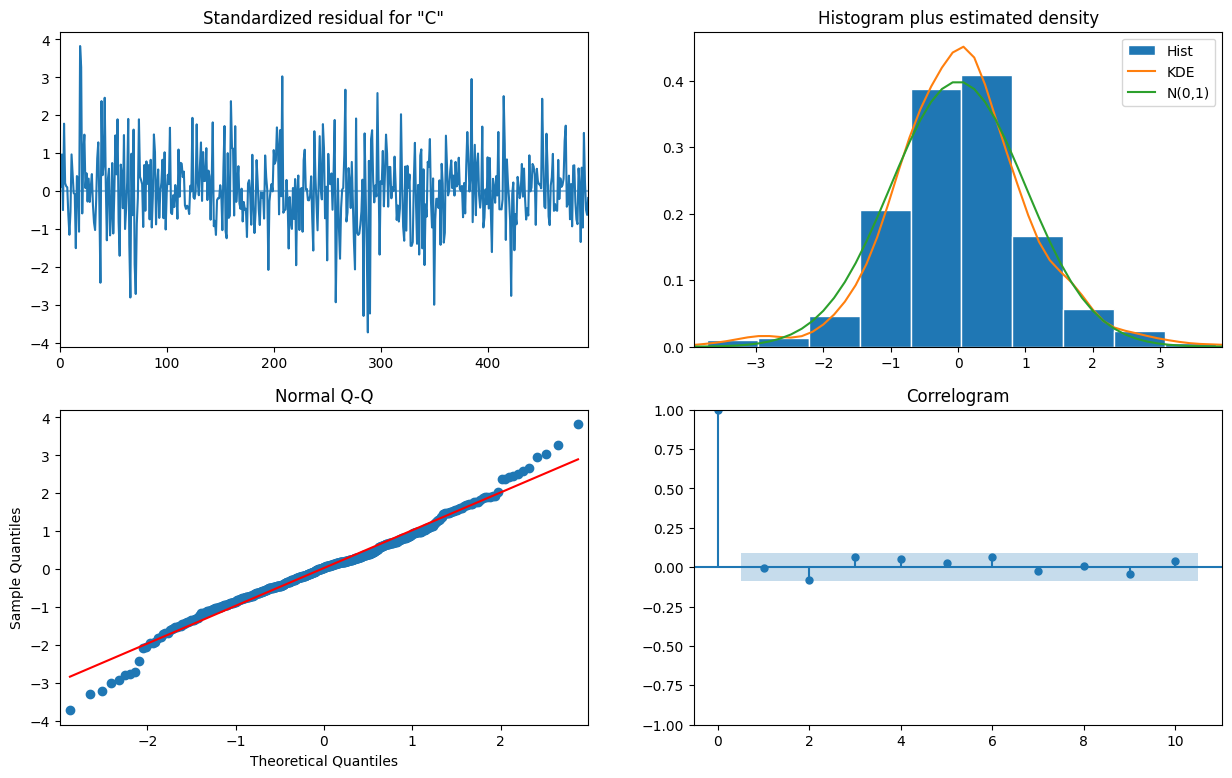

In [26]:
# plotting results
model_fit.plot_diagnostics(figsize=(15,9))
plt.show()

# Plotting the test data, baseline model predictions and optimized model predictions

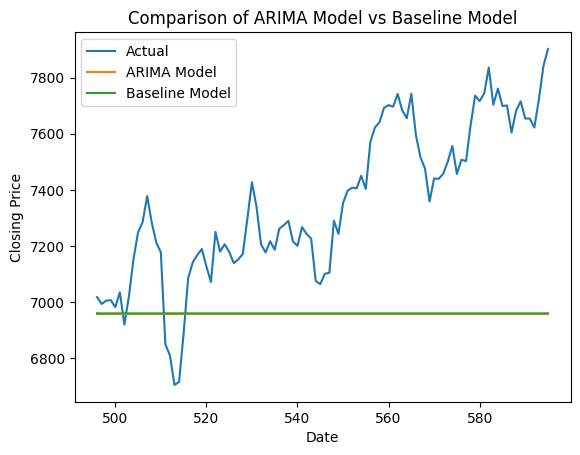

In [27]:
# Plot actual values
plt.plot(test.index, test['Close'], label='Actual')

# Plot ARIMA model predictions
plt.plot(arima_pred.index, arima_pred['predicted_mean'], label='ARIMA Model')

# Plot baseline model predictions
plt.plot(baseline_pred.index, baseline_pred['predicted_mean'], label='Baseline Model')

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Comparison of ARIMA Model vs Baseline Model')
plt.legend()
plt.show()

# Evaluating the two models using MAE, RMSE & MAPE

In [28]:
# Calculate evaluation metrics for ARIMA model
arima_mae = mean_absolute_error(test['Close'], arima_pred['predicted_mean'])
arima_rmse = mean_squared_error(test['Close'], arima_pred['predicted_mean'], squared=False)
arima_mape = np.mean(np.abs((test['Close'] - arima_pred['predicted_mean']) / test['Close'])) * 100

# Calculate evaluation metrics for baseline model
baseline_mae = mean_absolute_error(test['Close'], baseline_pred['predicted_mean'])
baseline_rmse = mean_squared_error(test['Close'], baseline_pred['predicted_mean'], squared=False)
baseline_mape = np.mean(np.abs((test['Close'] - baseline_pred['predicted_mean']) / test['Close'])) * 100

# Print the evaluation metrics
print("Evaluation Metrics:")
print("ARIMA Model - MAE:", arima_mae)
print("ARIMA Model - RMSE:", arima_rmse)
print("ARIMA Model - MAPE:", arima_mape)
print("Baseline Model - MAE:", baseline_mae)
print("Baseline Model - RMSE:", baseline_rmse)
print("Baseline Model - MAPE:", baseline_mape)

Evaluation Metrics:
ARIMA Model - MAE: 412.4750074008794
ARIMA Model - RMSE: 481.58453681812233
ARIMA Model - MAPE: 5.4963452804111474
Baseline Model - MAE: 410.82865234751216
Baseline Model - RMSE: 480.05265208537537
Baseline Model - MAPE: 5.4741599950228315


# Interpretation of the performance metrics

# Plotting the residuals of both the models

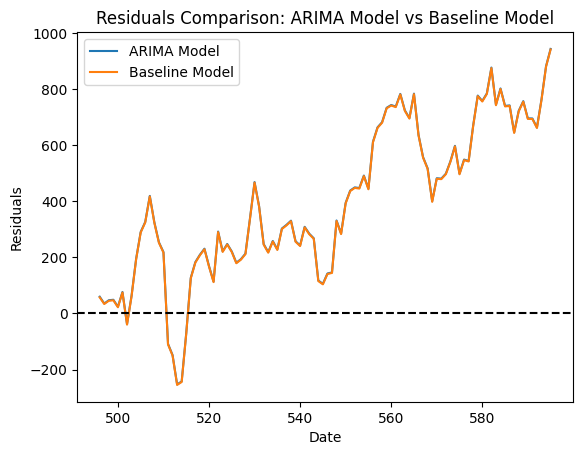

In [29]:
# Calculate residuals for ARIMA model
arima_residuals = test['Close'] - arima_pred['predicted_mean']

# Calculate residuals for baseline model
baseline_residuals = test['Close'] - baseline_pred['predicted_mean']

# Plot the residuals
plt.plot(test.index, arima_residuals, label='ARIMA Model')
plt.plot(test.index, baseline_residuals, label='Baseline Model')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals Comparison: ARIMA Model vs Baseline Model')
plt.legend()
plt.show()

# Plotting all the data alongwith the predictions of both the models

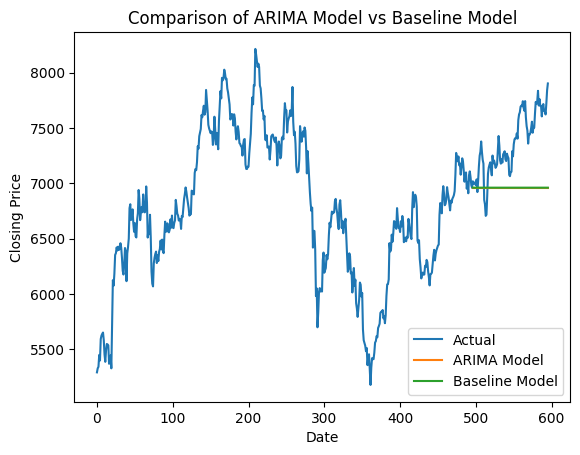

In [30]:
# Plot actual values
plt.plot(df.index, df['Close'], label='Actual')

# Plot ARIMA model predictions
plt.plot(arima_pred.index, arima_pred['predicted_mean'], label='ARIMA Model')

# Plot baseline model predictions
plt.plot(baseline_pred.index, baseline_pred['predicted_mean'], label='Baseline Model')

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Comparison of ARIMA Model vs Baseline Model')
plt.legend()
plt.show()